In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString, Point
import osmnx  as ox
import networkx as nx
import matplotlib.pyplot as plt

### 4. Function that gives back a plot with the shortest path

In [ ]:
# graph = ox.graph_from_place("Ottawa, Ontario, Canada", "bike")

# graph = ox.elevation.add_node_elevations_google(graph, api_key=API_KEY)
# graph = ox.elevation.add_edge_grades(graph)

# filepath = "./data/ottawa_bike_elevation.graphml"
# ox.save_graphml(graph, filepath)  

In [4]:
def shortest_path_map(origin, destination, network = 'bike'):
    '''origin and destination <geodataframe> crs 4326, network <str> drive, bike, walk
    return map including origins, destinations, shortest path and network
    '''
    
    # creating a frame for fetching OSM data
    combined = origin.append(destination)
    #print("Combined: ", combined)
    
    convex = combined.unary_union.convex_hull
    
    graph_extent = convex.buffer(0.02)
    
    # fetching graph
    graph = ox.load_graphml("./data/ottawa_bike_elevation.graphml")
    
    # define some edge impedance function here
    def impedance(length, grade):
        penalty = grade**2
        return length * penalty
    
    # add impedance and elevation rise values to each edge in the projected graph
    # use absolute value of grade in impedance function if you want to avoid uphill and downhill
    for _, _, _, data in graph.edges(keys=True, data=True):
        data["impedance"] = impedance(data["length"], data["grade"])
        data["rise"] = data["length"] * data["grade"]

    # graph = ox.graph_from_polygon(graph_extent, network_type= network)
    #print(graph.nodes(data=True)[391700968])
    
    # Reproject the graph
    graph_proj = ox.project_graph(graph)
    #print(graph_proj.nodes(data=True)[391700968])

    # Get the GeoDataFrame
    edges = ox.graph_to_gdfs(graph_proj, nodes=False)
    #edges.plot()
    
    # Get CRS info UTM
    CRS = edges.crs
    #print("CRS: ",CRS)
    
    # Reproject all data
    origin_proj = origin.to_crs(crs=CRS)
    destination_proj = destination.to_crs(crs=CRS)
    
    # routes of shortest path
    routes = gpd.GeoDataFrame()
    
    # Get nodes from the graph
    nodes = ox.graph_to_gdfs(graph_proj, edges=False)
    
     # Iterate over origins and destinations
    for oidx, orig in origin_proj.iterrows():
        
        # Find closest node from the graph --> point = (latitude, longitude)
        closest_origin_node = ox.nearest_nodes(graph_proj, orig.geometry.x, orig.geometry.y)
        
        # Iterate over targets
        for tidx, target in destination_proj.iterrows():
            # Find closest node from the graph --> point = (latitude, longitude)
            closest_target_node = ox.nearest_nodes(graph_proj, target.geometry.x, target.geometry.y)
            
            # Check if origin and target nodes are the same --> if they are --> skip
            if closest_origin_node == closest_target_node:
                print("Same origin and destination node. Skipping ..")
                continue
            
            # Find the shortest path between the points
            route = nx.shortest_path(graph_proj, 
                                     source=closest_origin_node, 
                                     target=closest_target_node, weight='impedance')
        
            # Extract the nodes of the route
            route_nodes = nodes.loc[route]
        
            # Create a LineString out of the route
            path = LineString(list(route_nodes.geometry.values))
        
            # Append the result into the GeoDataFrame
            routes = routes.append([[path]], ignore_index=True)

    # Add a column name
    routes.columns = ['geometry']
    
    # Set geometry
    routes = routes.set_geometry('geometry')
        
    # Set coordinate reference system
    routes.crs = nodes.crs

    
    plt.style.use('seaborn')
    
    # Plot
    ax = edges.plot(figsize=(16, 10), color='gray', linewidth=0.5, alpha=0.7)
    ax = origin_proj.plot(ax=ax, color='red')
    ax = destination_proj.plot(ax=ax, color='blue')
    ax = routes.plot(ax=ax, linewidth=3, alpha = 0.8, color = 'magenta')
    
    plt.axis('off')
    
    
    return ax

C:\Users\saif9\AppData\Local\Temp\ipykernel_9076\916505282.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined = origin.append(destination)
C:\Users\saif9\AppData\Local\Temp\ipykernel_9076\916505282.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  routes = routes.append([[path]], ignore_index=True)
C:\Users\saif9\AppData\Local\Temp\ipykernel_9076\916505282.py:93: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


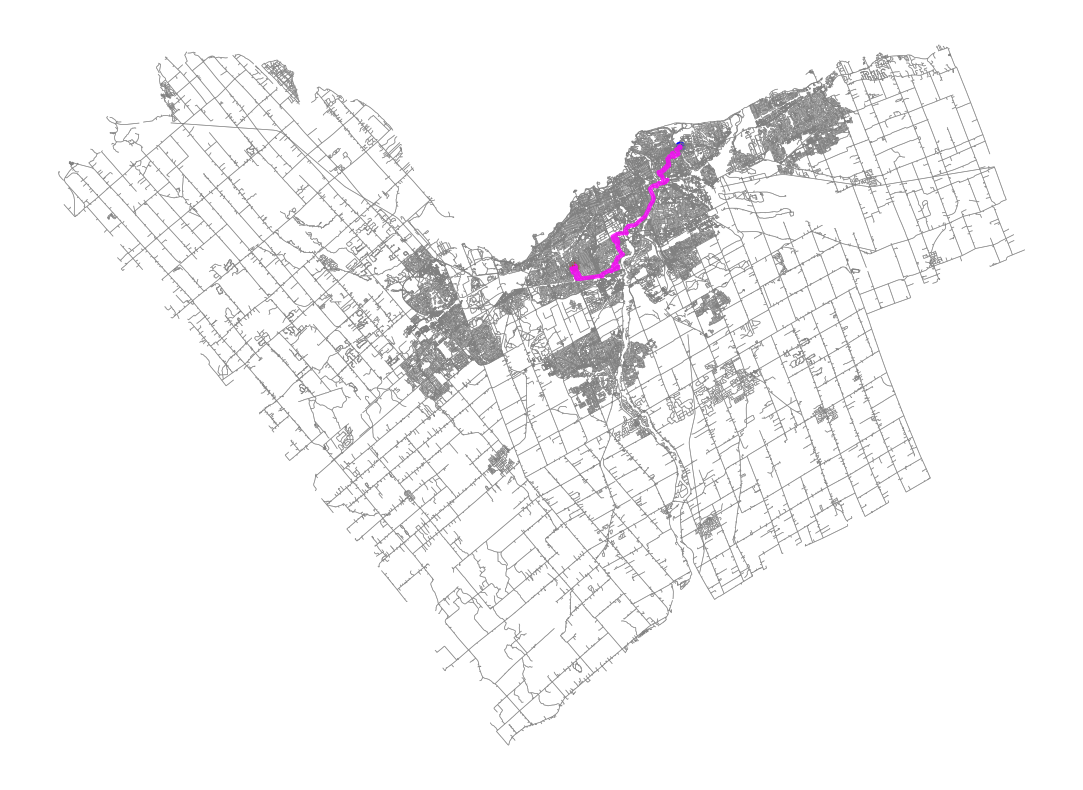

In [5]:
origin =  gpd.GeoDataFrame(columns = ['name', 'geometry'], crs = 4326, geometry = 'geometry')
origin.at[0, 'geometry'] = Point(-75.75723, 45.34900)
origin.at[0, 'name'] = 'Algonquin'

destination =  gpd.GeoDataFrame(columns = ['name', 'geometry'], crs = 4326, geometry = 'geometry')
destination.at[0, 'geometry'] = Point(-75.63844, 45.44515)
destination.at[0, 'name'] = 'Montfort'
destination

shortest_path_map(origin, destination, 'bike')
plt.savefig('cycling_network.png')